This file contains code to quantify differences in song structure and sequence based on sequence linearity, consistency and stereotypy [Sakata and Brainard 2006] and transition entropy [Scharff and Nottebohm 1991].

Date: 13/10/22

In [1]:
import math
import pandas
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from functools import reduce

In [124]:
#set directory
os.chdir('D:\\4th Year\\Semester 7\\BI4313 Sem Project\\IN-comparative-analysis\\IN-comparative-analysis\\test\\Bout_trans_prob')

file = pandas.read_csv('JF_ylw22gry08_bout_trans_prob.csv', header=None)
df = file.to_numpy()

#Drop the row and column labels, just keep the numeric values
trans_prob = file.iloc[1:, 1:]
trans_prob = np.array(trans_prob)
trans_prob = trans_prob.astype(float)

#Get the set of unique syllables for the individual with their own index (so convert array to list)
uniq_syl = file.iloc[0].to_numpy()
uniq_syl = np.delete(uniq_syl, 0)

Sequence Linearity

Number of unique syllables/Number of unique transitions

In [125]:
#SEQUENCE LINEARITY
#Number of unique syllables
n_syl = len(uniq_syl)

#To get the number of unique transitions, create an array with 1 whenever trans_prob > 0
#and get the sum of the array
trans_num = np.zeros_like(trans_prob)
trans_num[trans_prob > 0] = 1
n_trans = sum(map(sum, trans_num))

s_lin = n_syl/n_trans

print(f'Number of syllables: {n_syl}')
print(f'Number of transitions: {n_trans}')
print(f'Sequence linearity: {s_lin}')


Number of syllables: 9
Number of transitions: 18.0
Sequence linearity: 0.5


Sequence Consistency

Sum of typical transitions/Sum of all transitions

In [27]:
#SEQUENCE CONSISTENCY
#"The typical transition type for each note is operationally defined as the one most frequently encountered 
#(for introductory notes, the two most frequently encountered)."

#numerator - sum of typical transitions
typ_trans = np.max(trans_prob, axis = 1)
typ_sum = sum(typ_trans)

#denominator - sum of all transitions
trans_sum = sum(map(sum, trans_prob))

s_con = typ_sum/trans_sum

print(f'Sum of typical transitions: {typ_sum}')
print(f'Sum of all transitions: {trans_sum}')
print(f'Sequence consistency: {s_con}')

Sum of typical transitions: 7.98
Sum of all transitions: 11.950000000000001
Sequence consistency: 0.6677824267782426


Sequence Stereotypy

In [28]:
#SEQUENCE STEREOTYPY

s_stereo = (s_lin + s_con)/2

print(f'Sequence stereotypy: {s_stereo}')

Sequence stereotypy: 0.5213912133891213


Transition entropy

sum (-p * log2[p])

In [29]:
#TRANSITION ENTROPY
from math import nan

trans_entropy = trans_prob

for i in range(len(trans_entropy)):
    for j in range(len(trans_entropy)):
        trans_entropy[i, j] = -trans_entropy[i, j] * np.log2(trans_entropy[i, j])

trans_entropy[np.isnan(trans_entropy)] = 0
transition_entropy = sum(map(sum, trans_entropy))

transition_entropy

C:\Users\VASUDH~1\AppData\Local\Temp/ipykernel_13824/3832714603.py:8: RuntimeWarning: divide by zero encountered in log2
  trans_entropy[i, j] = -trans_entropy[i, j] * np.log2(trans_entropy[i, j])
C:\Users\VASUDH~1\AppData\Local\Temp/ipykernel_13824/3832714603.py:8: RuntimeWarning: invalid value encountered in double_scalars
  trans_entropy[i, j] = -trans_entropy[i, j] * np.log2(trans_entropy[i, j])


12.646335803345364

In [466]:
#Test matrix
#trans_prob = np.array([[1, 0, 0], [0, 0.5, 0], [0, 0, 0.25]])

C:\Users\VASUDH~1\AppData\Local\Temp/ipykernel_2044/3828241856.py:4: RuntimeWarning: divide by zero encountered in log2
  z = -x[i] * np.log2(x[i])
C:\Users\VASUDH~1\AppData\Local\Temp/ipykernel_2044/3828241856.py:4: RuntimeWarning: invalid value encountered in double_scalars
  z = -x[i] * np.log2(x[i])


nan


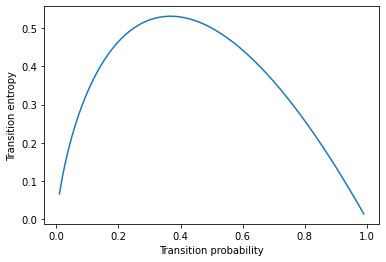

In [2]:

x = np.arange(0, 1, 0.01)
y = []
for i in range(0, len(x)):
    z = -x[i] * np.log2(x[i])
    y.append(z)

print(max(y))

plt.xlabel('Transition probability')
plt.ylabel('Transition entropy')
plt.plot(x, y)
plt.savefig('Transition entropy.png')

To calculate differences in syllable types, and initial syllables, intersyllable interval, amplitude and so on. For that, we need to to go back to Onset-Offset data and chunk the song bouts using 'Start' and 'End'

Number of starting syllables - value and fraction

In [30]:
#To get the number of transitions from 'Start'
syl_list = uniq_syl.tolist()
s = syl_list.index('Start') #get the idex of 'Start' row

#sum over Number of transitions matrix 'Start' row using the index
n_start = np.sum(trans_num[s])

print(f'Number of unique start syllables: {n_start}')
print(f'Fraction of unique start syllables: {n_start/n_syl}')

Number of unique start syllables: 4.0
Fraction of unique start syllables: 0.3333333333333333


In [117]:
#Get the indices at which 'End' exists to extract song bouts
#Import onset-offset data with 'Start-End' rows
os.chdir('D:\\4th Year\\Semester 7\\BI4313 Sem Project\\IN-comparative-analysis\\IN-comparative-analysis\\test\\Start_End')

data = pandas.read_csv('JF_ylw22gry08_start_end.csv', header=None,
        names = ['FileName', 'Syll #', 'Syll Label',
       ' Syll Onset (ms)', ' Syll Offset (ms)', ' Syll Duration (sec)', ' Mean Frequency (Hz)',
       ' Entropy', 'Log Amplitude (dB)', 'Pitch Goodness', 'FrequencyModulation',
       'AmplitudeModulation', 'EntropyVariance', 'Fundamental Frequency (Hz)', 'RMS Amplitude'])

syl = data['Syll Label']
all_syl = syl.tolist()

def find_end_indices(list, element):
    indices = [0]
    for idx, value in enumerate(list):
        if value == element:
            indices.append(idx)
    return indices

end_indices = find_end_indices(all_syl, 'End')
#print(end_indices)

song_bouts = []
for i in range(len(end_indices)-1):
    #For saving without 'Start' and 'End'
    x = data.iloc[end_indices[i] + 2 : end_indices[i+1], :]
    #x = data.iloc[end_indices[i] + 1 : end_indices[i+1] + 1, :]
    song_bouts.append(x)

print(len(song_bouts))

4


Next, we're going to calculate the inter-note interval, amplitude and frequency of notes along the song motif. For this, we're only going to work with song which have more syllables than half the average number.

In [118]:
#Define a function to pick song bouts that are long in length

def motif_finder(bouts_list):
    motif = bouts_list.copy()
    syll_num = []
    short_song_idx = []
    for i in range(len(bouts_list)):
        bout = bouts_list[i]
        syllable_list = bout['Syll Label'].tolist()
        syll_num.append(len(syllable_list))
    avg_syl_num = np.mean(syll_num)
    for i in range(len(syll_num)):
        if syll_num[i] < avg_syl_num/3:
            short_song_idx.append(i)
    #as each index is deleted, the list shortens, so indices have to be updated
    for i in range(len(short_song_idx)):
        short_song_idx[i] -= i
    for j in short_song_idx:
        del motif[j]
    return motif
    

song_motif = motif_finder(song_bouts)
#print(song_motif)

In [114]:
# def concatenate_bout_list(bout_list):
#     new_df = pandas.DataFrame()
#     for i in range(len(bout_list)): # big_df: dataframe list
#         # if i == 0:
#         #     new_df = bout_list[0]
#         new_df = pandas.concat([new_df, bout_list[i]])
#     start_row = [0, 0, 'Start', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#     new_df = pandas.DataFrame(np.insert(new_df.values, 0, start_row, axis=0))
#     return new_df
# x = concatenate_bout_list(song_motif)
# x.to_csv('test.csv', header=False)

In [41]:
#To check how song data is being stored in the list, you can print it out in a text file or check the length 
#of the list. Here, each element in the list is a Pandas dataframe

#Except for the first song bout, every other song bout starts with a 'Start' row 
#To avoid this, first syllable of first song can be lost, which seems fairer

# with open(r'D:\\4th Year\\Semester 7\\BI4313 Sem Project\\IN-comparative-analysis\\IN-comparative-analysis\\OnsetOffsetFiles\\ZF_org11pnk5_test_songbouts.txt', 'w') as fp:
#     for item in song_bouts:
#         fp.write("%s\n" % item)

# print(f'Number of song bouts is roughly about: {len(song_bouts)}')


1. Do the first syllables repeat in each song bout? 
2. Average number of syllables in each song bout

!! Make sure avg_syl/3 > 10 !!

In [119]:
#To calculate if the first syllable repeats, and if yes, how many times?
#Also get the number of syllables in each song

repeat_y_n = []
syll_num = []
syll_num_bouts = []

for i in range(len(song_motif)):
    bout = song_motif[i]
    syllable_list = bout['Syll Label'].tolist()
    syll_num.append(len(syllable_list))
    if len(syllable_list) > 3:
        if syllable_list[0] == syllable_list[1]:
            repeat_y_n.append(1)
        else:
            repeat_y_n.append(0)

for i in range(len(song_bouts)):
    bout = song_bouts[i]
    syllable_list = bout['Syll Label'].tolist()
    syll_num_bouts.append(len(syllable_list))

#mml - minimum motif length (for which we'll plot the plots)
mml = np.min(syll_num) - 1
#mml = 5
print(mml)

print(sum(repeat_y_n), repeat_y_n, syll_num, len(syll_num))
print(f'Average number of syllables in a song bout: {np.mean(syll_num)}')
#print(f'Fraction of times the first syllable is repeated: {sum(repeat_y_n)/len(repeat_y_n)}')


12
2 [0, 0, 1, 1] [16, 13, 13, 17] 4
Average number of syllables in a song bout: 14.75


In [15]:
np.min(syll_num)

9

In [5]:
mml = 8

3. Number of times the first syllable in a song bout repeats

In [121]:
#To count the number of repeated syllables in the beginning
repeat_num = []

for i in range(len(song_motif)):
    bout = song_motif[i]
    syllable_list = bout['Syll Label'].tolist()
    for t in range(1, len(syllable_list)):
        if syllable_list[t] != syllable_list[0]:
            first_syllable_repeats = t
            break
    repeat_num.append(first_syllable_repeats)

print(repeat_num, len(repeat_num))
print(f'Average number of repeats of first syllable is: {np.mean(repeat_num)}')
#print(len(repeat_num))

[1, 1, 2, 2] 4
Average number of repeats of first syllable is: 1.5


Instead of counting the number of repeats in each song bout, we can also get the weighted average of self-transition probability of the starting syllables

In [127]:
#To find the average self-transition probability of the first syllables after start
syl_list = uniq_syl.tolist()
s = syl_list.index('Start')

trans_num = np.zeros_like(trans_prob)
trans_num[trans_prob > 0] = 1

def find_indices(list, element):
    indices = []
    for idx, value in enumerate(list):
        if value == element:
            indices.append(idx)
    return indices

first_syl = trans_num[s].tolist()
print(first_syl)
first_syl_idx = find_indices(first_syl, 1)

first_syl_trans = []
for i in first_syl_idx:
    first_syl_trans.append(trans_prob[i,i] * trans_prob[s,i])

print(first_syl_trans)
print(np.mean(first_syl_trans))

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0825, 0.09]
0.08625


In [138]:
song_dur = []

for i in range(len(song_motif)):
    bout = song_motif[i]
    onset = bout[' Syll Onset (ms)'].tolist()
    offset = bout[' Syll Offset (ms)'].tolist()
    t_start = float(onset[0])
    t_end = float(offset[len(bout)-1])
    diff = t_end - t_start
    dur = round(diff/1000, 2)
    song_dur.append(dur)

avg_song_dur = np.mean(song_dur)
print(song_dur)
print(avg_song_dur)

[3.99, 4.41, 5.22, 4.48]
4.525


In [36]:
print(f'Number of syllables: {n_syl}')

print(f'Number of transitions: {n_trans}')

print(f'Number of unique start syllables: {n_start}')

print(f'Average number of repeats of first syllable is: {np.mean(repeat_num)}')

print(np.mean(first_syl_trans))

print(f'Average number of syllables in a song bout: {np.mean(syll_num)}')

print(f'Sequence linearity: {s_lin}')

print(f'Sequence consistency: {s_con}')

print(f'Sequence stereotypy: {s_stereo}')

transition_entropy

Number of syllables: 12
Number of transitions: 32.0
Number of unique start syllables: 4.0
Average number of repeats of first syllable is: 1.75
0.17754361907646915
Average number of syllables in a song bout: 15.375
Sequence linearity: 0.375
Sequence consistency: 0.6677824267782426
Sequence stereotypy: 0.5213912133891213


12.646335803345364

Syllable duration, amplitude, inter-note interval, song duration of various bird species

Syllable amplitude plots

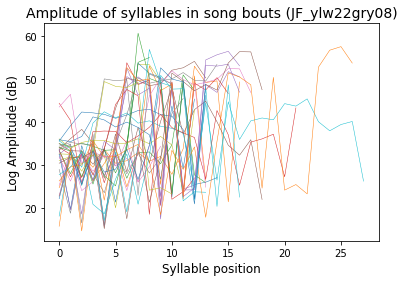

In [17]:
#To plot the log amplitude of syllables 

for i in range(len(song_motif)):
    bout = song_motif[i]
    amplitude = bout['Log Amplitude (dB)']
    amplitude = amplitude.tolist()
    x = np.arange(len(bout))
    plt.plot(x, amplitude, linewidth = 0.5)


plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Log Amplitude (dB)', fontsize = 12)
plt.title('Amplitude of syllables in song bouts (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('01 amplitude all syllables JF_ylw22gry08.png', dpi = 600)

Text(0.5, 1.0, 'Amplitude of initial syllables (JF_ylw22gry08)')

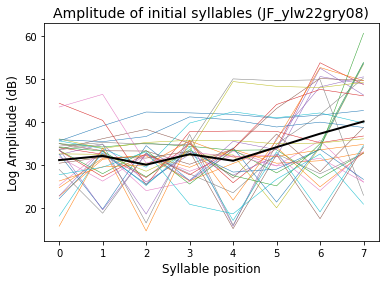

In [18]:
#To try and calculate the average amplitude at each syllable index
from statistics import mean

amp = []
for i in range(len(song_motif)):
    a = song_motif[i]['Log Amplitude (dB)']
    a = a.tolist()[:mml]
    amp.append(a)

amp_10syl = np.array([np.array(i) for i in amp])

def mean_value(data):
    avg = []
    for i in range(len(data[0])):
        temp = []
        for j in range(len(data)):
            t = data[j, i]
            temp.append(t)
        avg.append(np.mean(temp))
    return avg

#print(amp_10syl)
#print(mean_value(amp_10syl))

#To plot the log amplitude of syllables 

for i in range(len(song_motif)):
    bout = song_motif[i]
    amplitude = bout['Log Amplitude (dB)']
    amplitude = amplitude.tolist()[:mml]
    x = np.arange(mml)
    plt.plot(x, amplitude, linewidth = 0.5)

#plot the average values of first 10 syllables
xaxis = np.arange(mml)
plt.plot(xaxis, mean_value(amp_10syl), 'k', linewidth = 2)

plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Log Amplitude (dB)', fontsize = 12)
plt.title('Amplitude of initial syllables (JF_ylw22gry08)', fontsize = 14)

#plt.show()
#plt.savefig('02 amplitude init syll JF_ylw22gry08.png', dpi = 600)

Syllable duration plots

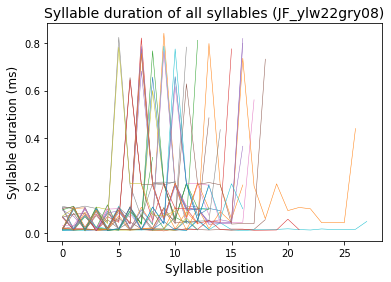

In [9]:
#Syllable durations

for i in range(len(song_motif)):
    bout = song_motif[i]
    dur = bout[' Syll Duration (sec)']
    dur = dur.tolist()
    x = np.arange(len(bout))
    plt.plot(x, dur, linewidth = 0.5)


plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Syllable duration (ms)', fontsize = 12)
plt.title('Syllable duration of all syllables (JF_ylw22gry08)', fontsize = 14)

plt.get_cmap('viridis')
#plt.show()
plt.savefig('03 duration all syllables JF_ylw22gry08.png', dpi = 600)

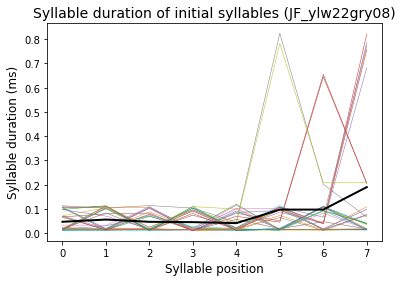

In [10]:
#Syllable durations

duration = []
for i in range(len(song_motif)):
    d = song_motif[i][' Syll Duration (sec)']
    d = d.tolist()[:mml]
    duration.append(d)

dur_10syl = np.array([np.array(i) for i in duration])

for i in range(len(song_motif)):
    bout = song_motif[i]
    dur = bout[' Syll Duration (sec)']
    dur = dur.tolist()[:mml]
    x = np.arange(mml)
    plt.plot(x, dur, linewidth = 0.5)

#plot the average values of first 10 syllables
xaxis = np.arange(mml)
plt.plot(xaxis, mean_value(dur_10syl), 'k', linewidth = 2)

plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Syllable duration (ms)', fontsize = 12)
plt.title('Syllable duration of initial syllables (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('04 duration init syllables JF_ylw22gry08.png', dpi = 600)

Inter-note interval plots

In [11]:
#Calculating inter-note interval

def intervals(song_list):
    intervals = []
    for i in range(len(song_list)):
        bout = song_list[i]
        in_int = []
        start = np.array(bout[' Syll Onset (ms)'])
        stop = np.array(bout[' Syll Offset (ms)'])
        for j in range(1, len(bout)):
            diff = start[j] - stop[j-1]
            in_int.append(diff)
        intervals.append(in_int)

    return intervals

internote_int = intervals(song_motif)


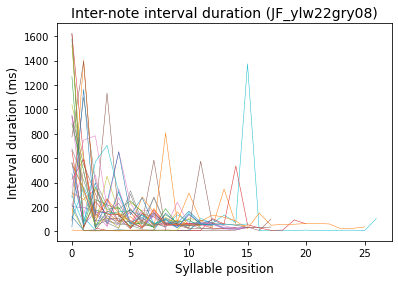

In [12]:
#To plot inter-not intervals

for i in range(len(internote_int)):
    y = internote_int[i]
    x = np.arange(len(y))
    plt.plot(x, y, linewidth = 0.5)

plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Interval duration (ms)', fontsize = 12)
plt.title('Inter-note interval duration (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('05 interval all syllables JF_ylw22gry08.png', dpi = 600)

C:\Users\VASUDH~1\AppData\Local\Temp/ipykernel_21092/3640815206.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  int_all_syl = np.array([np.array(i) for i in internote_int])


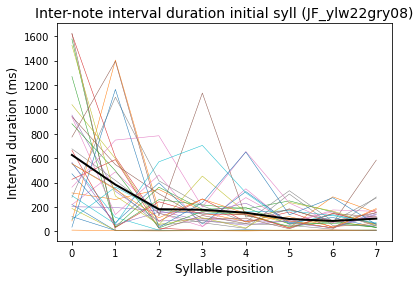

In [13]:
#To plot first 10 internote interval duration

int_all_syl = np.array([np.array(i) for i in internote_int])
int_10syl = []

for i in range(len(int_all_syl)):
    b = int_all_syl[i]
    b = b.tolist()
    b = b[:mml]
    int_10syl.append(b)

#int_10syl = np.array(int_10syl)
int_10syl = np.array([np.array(i) for i in int_10syl])

for i in range(len(internote_int)):
    y_temp = internote_int[i]
    y = y_temp[:mml]
    x = np.arange(len(y))
    plt.plot(x, y, linewidth = 0.5)

xaxis = np.arange(mml)
plt.plot(xaxis, mean_value(int_10syl), 'k', linewidth = 2)

plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Interval duration (ms)', fontsize = 12)
plt.title('Inter-note interval duration initial syll (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('06 interval syllables JF_ylw22gry08.png', dpi = 600)

Syllable mean frequency plots

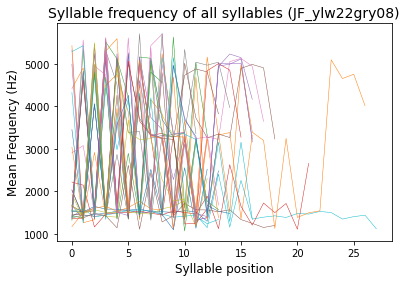

In [15]:
#Syllable frequency

for i in range(len(song_motif)):
    bout = song_motif[i]
    freq = bout[' Mean Frequency (Hz)']
    freq = freq.tolist()
    x = np.arange(len(bout))
    plt.plot(x, freq, linewidth = 0.5)


plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Mean Frequency (Hz)', fontsize = 12)
plt.title('Syllable frequency of all syllables (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('07 frequency all syllables JF_ylw22gry08.png', dpi = 600)

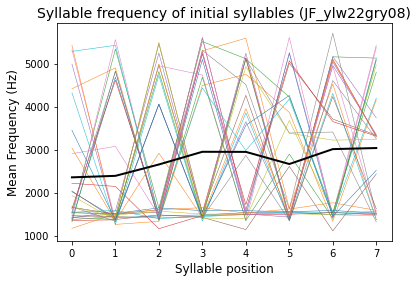

In [16]:
#Syllable mean frequency

frequency = []
for i in range(len(song_motif)):
    f = song_motif[i][' Mean Frequency (Hz)']
    f = f.tolist()[:mml]
    frequency.append(f)

freq_10syl = np.array([np.array(i) for i in frequency])

for i in range(len(song_motif)):
    bout = song_motif[i]
    freq = bout[' Mean Frequency (Hz)']
    freq = freq.tolist()[:mml]
    x = np.arange(mml)
    plt.plot(x, freq, linewidth = 0.5)

#plot the average values of first 10 syllables
xaxis = np.arange(mml)
plt.plot(xaxis, mean_value(freq_10syl), 'k', linewidth = 2)

plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Mean Frequency (Hz)', fontsize = 12)
plt.title('Syllable frequency of initial syllables (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('08 frequency init syllables JF_ylw22gry08.png', dpi = 600)